Introduction
================
https://ml-cheatsheet.readthedocs.io/en/latest/linear_regression.html

Linear Regression is a supervised machine learning algorithm where the predicted output is continuous and has a constant slope. It’s used to predict values within a continuous range, (e.g. sales, price) rather than trying to classify them into categories (e.g. cat, dog). There are two main types:

**Simple regression**

Simple linear regression uses traditional slope-intercept form, where m and b are the variables our algorithm will try to “learn” to produce the most accurate predictions. x represents our input data and y represents our prediction.

y=mx+b

**Multivariable regression**

A more complex, multi-variable linear equation might look like this, where w represents the coefficients, or weights, our model will try to learn.

f(x,y,z)=w1x+w2y+w3z


Given our simple linear equation y=mx+b, we can calculate MSE as:

$ MSE = \frac{1}{N}\sum_{i=1}^{n}(y_{i}-(mx_{i}+b))^{2} $

We then aim to minismise this by varying the weights of the model such that the MSE is reduced, moving upwards the gradient of the cost function.

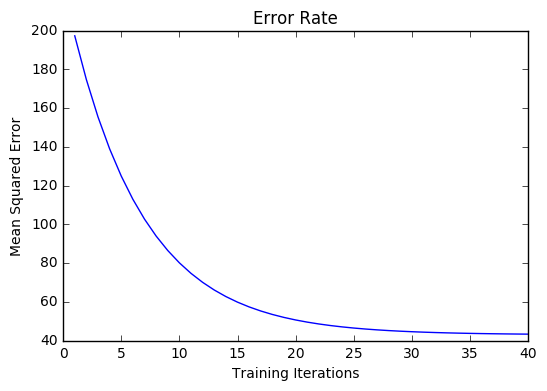


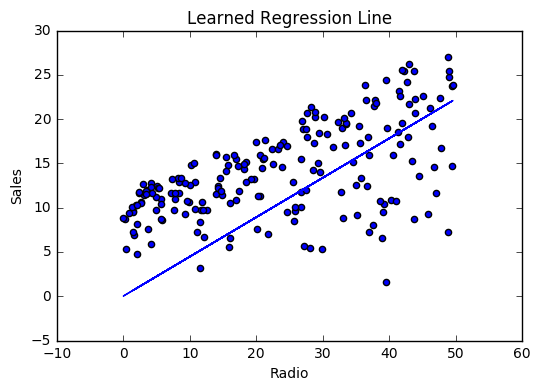

In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format ='retina'
%matplotlib inline

In [231]:
dataset = pd.read_csv('framingham.csv')
dataset.head()
dataset.columns

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

Pre processing
----------
The following code contains a series of pre-processing functions that can be used to greatly increase speed of improvement of any ML algorythm.

* Selecting features
* Dealing with missing values
* Dealing with outliers
* Feature scaling 
* Splitting dataset

Select features that are input into model. These could be chosen based on what are considered to be the most important features (from Eleanor Barr or my feature importance functions.)

Then split the dataset into test + train

Selecting Features
------------------------

In [254]:
'''Selecting features - dropping uninteresting columns'''

def chose_features(dataset, features=dataset.columns, n_features = -1, v=1, vv =0):
    '''Return reduced dataset with only chosen columns
    - dataset: pandas dataframe of dataset to have columns chosen
    - features (optional, default = all features): list of strings matching features to keep
    - n_features (optional) - if specified, the top n features from the scaled list is chosen: 
    ['glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp',
        'diabetes', 'BPMeds', 'male', 'BMI', 'prevalentStroke',
        'education', 'heartRate', 'currentSmoker'],
    - v (optional) - Verbose (default 1) int 0 or 1. Print no. of features kept and lost 
    - vv (optional) - Very verbose (default 0) int 0 or 1. Print list of chosen and rejected features
    '''
                
    print('Now selecting chosen features....')
    
    if n_features != -1:
        if n_features > len(dataset.columns):
            print('WARNING: chose_features has an error: n_features must be less than no. columns')
            return(-1)
        else:
            ordered_f = ['TenYearCHD','glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp',
            'diabetes', 'BPMeds', 'male', 'BMI', 'sysBP','prevalentStroke',
            'education', 'heartRate', 'currentSmoker']
            features = ordered_f[0:n_features]

    if v == 1: 
        print('\t * Number of features: ', len(features))
        print('\t * Number of dropped features: ', len(dataset.columns) - len(features))
        
    if vv == 1:
        print('\t * Chosen features: ', features)
        print('\t * Dropped features: ',[col for col in dataset.columns if col not in features])
    print('')
    
    return dataset.copy()[features] #reduced dataset


'Selecting features - dropping uninteresting columns'

In [255]:
##e.g.

features = ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp',
       'diabetes', 'BPMeds', 'male', 'BMI', 'TenYearCHD'] # this is top 10 features (and 10YrCHD) from Ellie's 'graph_analysis_EB'

a = chose_features(dataset, n_features=10, vv=1)
a = chose_features(dataset, features=features, vv=1)
a.head(2)

Now selecting chosen features....
	 * Number of features:  10
	 * Number of dropped features:  6
	 * Chosen features:  ['TenYearCHD', 'glucose', 'age', 'totChol', 'cigsPerDay', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male']
	 * Dropped features:  ['education', 'currentSmoker', 'prevalentStroke', 'sysBP', 'BMI', 'heartRate']

Now selecting chosen features....
	 * Number of features:  11
	 * Number of dropped features:  5
	 * Chosen features:  ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male', 'BMI', 'TenYearCHD']
	 * Dropped features:  ['education', 'currentSmoker', 'prevalentStroke', 'heartRate', 'glucose']



,sysBP,age,cigsPerDay,totChol,diaBP,prevalentHyp,diabetes,BPMeds,male,BMI,TenYearCHD
0,106.0,39,0.0,195.0,70.0,0,0,0.0,1,26.97,0
1,121.0,46,0.0,250.0,81.0,0,0,0.0,0,28.73,0


Dealing with missing values
-------------
* Dropping missing values
* Imputation
    * Mean or median

In [256]:
'''Dealing with missing values'''

#Method 1: Drop missing values
def drop_missing(dataset):
    '''Drop rows with any missing values and return dataset with dropped rows. Prints number and percentage of rows dropped
    - Dataset: pandas Dataframe
    '''
    print('Now dropping rows with missing values....')
    dataset2 = dataset.copy().dropna().reset_index(drop=True)
    lost = len(dataset) - len(dataset2)
    print('\t * Dropped {} rows {:.1f}%. {} rows remaining\n'.format(lost,lost/len(dataset)*100,len(dataset2)))
    return dataset2


'Dealing with missing values'

In [257]:
##e.g. if using all columns 
col_interestedin = dataset.columns
a = drop_missing(chose_features(dataset,col_interestedin, vv =1))

##e.g. if using top 10 columns columns
col_interestedin = ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp',
       'diabetes', 'BPMeds', 'male', 'BMI'] # this is top 10 features from Ellie's 'graph_analysis_EB'
a = drop_missing(chose_features(dataset,col_interestedin, vv =1))

Now selecting chosen features....
	 * Number of features:  16
	 * Number of dropped features:  0
	 * Chosen features:  Index(['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')
	 * Dropped features:  []

Now dropping rows with missing values....
	 * Dropped 582 rows 13.7%. 3658 rows remaining

Now selecting chosen features....
	 * Number of features:  10
	 * Number of dropped features:  6
	 * Chosen features:  ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male', 'BMI']
	 * Dropped features:  ['education', 'currentSmoker', 'prevalentStroke', 'heartRate', 'glucose', 'TenYearCHD']

Now dropping rows with missing values....
	 * Dropped 149 rows 3.5%. 4091 rows remaining



In [258]:
#Method 2: Imputation (of mean or median)
def impute_missing(dataset, strategy = 'median', v=1, vv=0):
    '''Imputation - alternative to removing missing values.
    Fill all missing with column average (median or mean)
    dataset - Pandas Dataframe to be imputed
    strategy - str (optional) 'median' (default) or 'mean' to fill missing values with
    - v (optional) - Verbose (default 1) int 0 or 1. Print no. of missing and imputed values  
    - vv (optional) - Very verbose (default 0) int 0 or 1. Print list of imputed features with counts and replaced value
    '''
    from sklearn.impute import SimpleImputer
    my_imputer = SimpleImputer(strategy=strategy)
    dataset2 = pd.DataFrame(my_imputer.fit_transform(dataset),columns=dataset.columns)
    
    if v == 1: 
        print('Imputing missing values with {}....'.format(strategy))
        print('\t * Number of missing values: ', dataset.isna().sum().sum())
        print('\t * Number of imputed values: ', dataset.isna().sum().sum() - dataset2.isna().sum().sum())
        print('\n')
    if vv == 1:
        subbed = pd.DataFrame(dataset.isna().sum().sort_values(ascending=False),columns=['N_missing'])
        subbed= subbed.assign(Imputed_value=np.NaN)
        for col in subbed.index:
            if strategy == 'median':
                subbed.loc[col,'Imputed_value'] = dataset[col].median()
            elif strategy == 'mean':
                subbed.loc[[col,'Imputed_value']] = dataset[col].mean()
        print(subbed)
    
    return dataset2


In [259]:
##e.g. if using all columns 
a = impute_missing(dataset, vv=1)

##e.g. if using top 10 columns columns
a = impute_missing(chose_features(dataset,col_interestedin), vv=1)

Imputing missing values with median....
	 * Number of missing values:  645
	 * Number of imputed values:  645


                 N_missing  Imputed_value
glucose                388           78.0
education              105            2.0
BPMeds                  53            0.0
totChol                 50          234.0
cigsPerDay              29            0.0
BMI                     19           25.4
heartRate                1           75.0
TenYearCHD               0            0.0
diaBP                    0           82.0
sysBP                    0          128.0
diabetes                 0            0.0
prevalentHyp             0            0.0
prevalentStroke          0            0.0
currentSmoker            0            0.0
age                      0           49.0
male                     0            0.0
Now selecting chosen features....
	 * Number of features:  10
	 * Number of dropped features:  6

Imputing missing values with median....
	 * Number of missing values:  151
	

Feature Scaling
------------
As the number of features grows, calculating gradient takes longer to compute. We can speed this up by “normalizing” our input data to ensure all values are within the same range. This is especially important for datasets with high standard deviations or differences in the ranges of the attributes. Build a few functions for 

In [ ]:
def mean_normalize(dataset):
    '''
    Normalise all features in a dataframe between -1 and 1 and return normalised dataframe.
    This is one method of feature scaling that may aid the performace of some ML algorithms
    Normalisation: (feature - mean)/range
    '''

    for feature in dataset:
        
        fmean = np.mean(dataset[feature])
        frange = np.amax(dataset[feature]) - np.amin(dataset[feature])

        #Vector Subtraction
        dataset[feature] = dataset[feature] - fmean
        #Vector Division
        dataset[feature] = dataset[feature] / frange

    return dataset

##e.g.
#dataset_n = mean_normalize(dataset.copy())
#dataset_n.head()

##I then found there were some build in normalisation/ scaling modules in sklearn.preprocessing so tried some of these


def scale_data(data, method='std'):
    '''Return dataset scaled by MinMaxScalar or StandardScalar methods from sklearn.preprocessing
    - data: pandas dataframe of data to be scaled
    - method (optional): str of either 'minmax' for MinMaxScalar or 'std' for StandardScaler (default arg)
    '''
    from sklearn import preprocessing
    
    if method == 'minmax':
        scaler_minmax = preprocessing.MinMaxScaler((0,1))
        return pd.DataFrame(scaler_minmax.fit_transform(data.copy()),columns=data.columns) 
    
    elif method == 'std':
        scaler_std = preprocessing.StandardScaler() #with_std=False
        return pd.DataFrame(scaler_std.fit_transform(dataset.copy()),columns=dataset.columns)
    
    else:
        print('\nscale_data encountered a failure!!\n')
        return(-1)

##e.g.
##scale_data(dataset).head()



Splitting dataset
--------------

In [4]:
def split_data(dataset,dep_var='TenYearCHD', test_size = 0.2, v = 1):
    '''Split the dataset, return X_train, X_test, y_train, y_test as Pandas Dataframes
    - dataset: Pandas Dataframe. Data to split into training and test data
    - dep_var (optional, default = 'TenYearCHD'): string. Name of column to be dependant variable
    - test_size (optional, default = 0.2): float (0.0-1.0). Proportion of total data to make up test set.
    '''
    from sklearn.model_selection import train_test_split
    y = dataset[dep_var]
    X = dataset.drop([dep_var], axis = 1)
    if v == 1: 
          print('Splitting data set into {}% training, {}% test dataset....'.format(100*(1-test_size),100*test_size))
        
    return train_test_split(X, y, test_size = test_size, random_state=0)



                                              

Logistic Regression
-----------------

In [352]:
def log_regressor(X_train, X_test, y_train, y_test, v =0):
    '''Do linear regression fitting and print information about the success of the fitting
    - X_train: Dataframe x training set
    - y_train: Dataframe y training set
    - X_test: Dataframe x test set
    - y_test: Dataframe y test set
    - v (optional, default = 0): int (0 or 1) verbose
    '''
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

    print('\nCalculating linear regressor...\n')
    logreg = LogisticRegression(random_state=0)
    logreg.fit(X_train, y_train) 
    y_pred = logreg.predict(X_test)
    
    if v == 1: 
        print(logreg)
        print('Confusion Matrix:')
        cm=confusion_matrix(y_test,y_pred)
        conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
        print(confusion_matrix(y_test,y_pred))
    
        print('Accuracy: {:.2f}%'.format(accuracy_score(y_test,y_pred)*100))

        print(classification_report(y_test,y_pred))
    
    return accuracy_score(y_test,y_pred)
    


Testing the regression!
---------------

In [366]:
# Finally use all the functions I made to preprocess dataset:
features = dataset.columns #try all columns

dataset_t = chose_features(dataset, n_features=16) # choose n features
dataset_t = drop_missing(dataset_t) # drop missing rows
X_train, X_test, y_train, y_test = split_data(dataset_t) # split dataset

accuracy = log_regressor(X_train, X_test, y_train, y_test, v =0)
print('Accuracy {:.2f}%: '.format(accuracy*100))

Now selecting chosen features....
	 * Number of features:  16
	 * Number of dropped features:  0

Now dropping rows with missing values....
	 * Dropped 582 rows 13.7%. 3658 rows remaining

Splitting data set into 20.0% training, 80.0% test dataset....

Calculating linear regressor...

Accuracy 83.88%: 


C:\Users\lewma\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Calculating linear regressor...

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Confusion Matrix:


C:\Users\lewma\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 576x360 with 0 Axes>

[[604   5]
 [113  10]]
Accuracy: 83.88%
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       609
           1       0.67      0.08      0.14       123

   micro avg       0.84      0.84      0.84       732
   macro avg       0.75      0.54      0.53       732
weighted avg       0.81      0.84      0.78       732



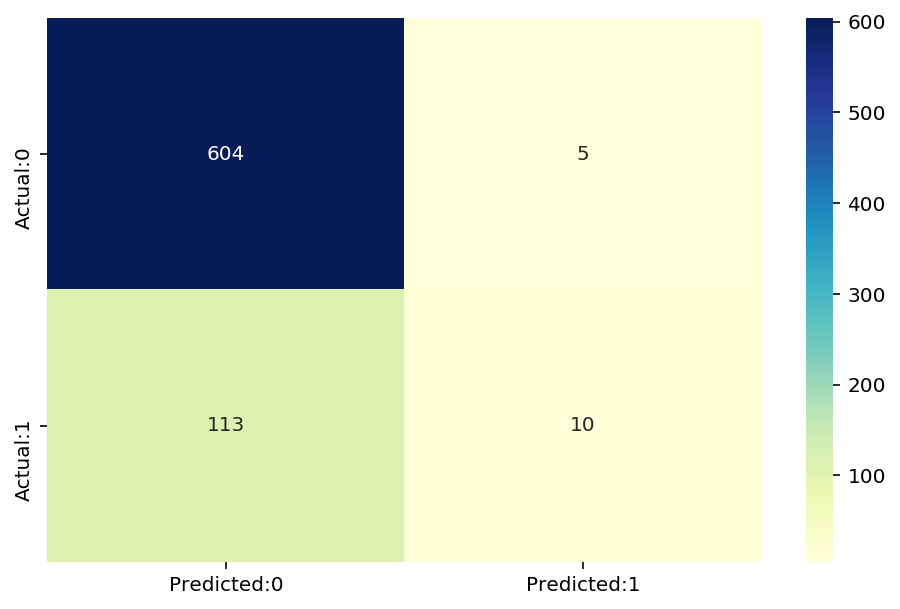

In [351]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print('\nCalculating linear regressor...\n')
logreg = LogisticRegression(random_state=0)
logreg = logreg.fit(X_train, y_train)
print(logreg)

y_pred = logreg.predict(X_test)

print('Confusion Matrix:')
cm=confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
print(confusion_matrix(y_test,y_pred))

print('Accuracy: {:.2f}%'.format(accuracy_score(y_test,y_pred)*100))

print(classification_report(y_test,y_pred))



The following is implemented above

In [3]:
count=0
for i in dataset.isnull().sum(axis=1):
    if i>0:
        count=count+1
if count>0:
    print(count, 'Rows(or', round((count/len(dataset.index))*100), '%) with missing values are dropped out of total', str(len(dataset.index)))
    dataset.dropna(axis=0,inplace=True)
    print('Now dataset has', len(dataset.index),' rows')

582 Rows(or 14 %) with missing values are dropped out of total 4240
Now dataset has 3658  rows


In [14]:
X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [15]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
y_pred = classifier.predict(X_test)

In [17]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[604   5]
 [112  11]]


In [18]:
from sklearn.metrics import accuracy_score as score
print('Accuracy:')
print(score(y_test,y_pred)*100)

Accuracy:
84.01639344262296
